# Выполнил: Горбецкий Дмитрий

## Задача 1

В парикмахерской работают 3 мастера, а в зале ожидания расположены 3 стула. Поток клиентов имеет интенсивность 12 клиентов в час. Среднее время обслуживания составляет 20 мин. Определить показатели работы СМО.

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
from math import factorial

## Аналитическое решение
#### Начнем заполнять основные показатель работы СМО:
В нашем случае это многоканальное СМО смешенного типа с ограничением на очередь. За единицу времени будем принимать астрономический час. Сначала выпишем условие и простые показатели, которые можно посчитать на его основании в стандартных обозначениях СМО

1. Число каналов $n = 3$
2. Максимальная очередь (зал ожидания) $m = 3$
3. Интенсивность входящего потока $\lambda = 12$ 
4. Среднее время обслуживания одной заявки $\overline{T}_{об} = {20\over{60}} = {1\over{3}}$
5. Интенсивность потока обслуживания $\mu = {1\over{\overline{T}_{об}}} = 3$ 
6. Интенсивность нагрузки каналов $\rho = {\lambda\over\mu} = 4$
7. Интенсивность нагрузки *одного* канала ${\rho\over n} = {4 \over 3}$


Прейдем к более сложным вычислениям:

8. Вероятность того, что СМО свободна и может обслужить заявку $p_{0}=\frac{1}{\sum_{i=0}^{n} \frac{\rho^{i}}{i !}+\frac{\rho^{n+1}}{n!(n-\rho)}\left(1-\left(\frac{\rho}{n}\right)^{m}\right)} \approx 0.0121 $


In [2]:
ro, m, n = 4, 3, 3
p0 = 1/((1 + ro + ro**2/factorial(2) + ro**3/factorial(3)) + ro**(n+1)/(factorial(n)*(n-ro)) * (1-(ro/n)**m))
p0

0.012174958665263795

9. Вероятность отказа $P_{\text {oтк }} = P_{n+m}=\frac{\rho^{n+m} P_{0}}{n ! n^{m}} \approx 0.308$

In [3]:
Pnm = (ro**(n+m)*p0)/(factorial(n)*n**m)
Pnm 

0.30783105366000313

10. Относительная пропускная способность $Q=1-P_{\text {oтк }}  \approx 0.692$
11. Абсолютная пропускная способность $A=\lambda Q\approx 8.31$
12. Среднее число занятых каналов $\bar{k}=\frac{A}{\mu} \approx 2.77$
13. Средняя длина очереди $L=\frac{P_{0} \rho^{n}\left(\frac{\rho}{n}-(m+1)\left(\frac{\rho}{n}\right)^{m+1}+m\left(\frac{\rho}{n}\right)^{m+2}\right)}{n !\left(1-\frac{\rho}{n}\right)^{2}} \approx 1.56$

In [4]:
Q = 1 - Pnm
Q

0.6921689463399969

In [5]:
A = 12 * Q 
A

8.306027356079962

In [6]:
k = A / 3 
k

2.7686757853599873

In [7]:
L = (p0*ro**n*(ro/n - (m+1)*(ro/n)**(m+1) + m*(ro/n)**(m+2)))/(factorial(n)*(1-ro/n)**2)
L

1.558394709153765

14. Среднее время ожидания обслуживания в очереди $t = {L \over \lambda} \approx 0.13 $
15. Среднее число заявок в СМО $М = L + \bar{k} \approx 4.33$
16. Среднее время пребывания заявки в СМО $T = {M \over \lambda} \approx 0.36$

In [8]:
t = L / 12
t

0.12986622576281376

In [9]:
M = L + k
M

4.327070494513753

In [10]:
T = M / 12
T

0.36058920787614607

## ИМ модель

In [11]:
MASTERS = 3
MAX_WAIT_ZONE = 3
CLIENT_PER_HOUR = 12
HAIR_CUT_TIME = 1/3

In [12]:
class Barber_shop(object):
    def __init__(self, env):
        self.env = env
        self.master = simpy.Resource(env, capacity=MASTERS)

    def hair_cut(self, client):
         yield self.env.timeout(np.random.exponential(HAIR_CUT_TIME))

In [13]:
def go_to_barber_shop(env, client, barber_shop):
    arrival_time = env.now
    len_queue.append(len(barber_shop.master.queue)) # длина очереди 
    clients_in_CMO.append(len(barber_shop.master.queue) + len(barber_shop.master.users)) # количество заявок в СМО
    clients_in_process.append(len(barber_shop.master.users)) # число занятых каналов
        
    if len(barber_shop.master.queue) >= MAX_WAIT_ZONE:  # Ограничение на очередь в 3 человека
        global clients_gone
        wait_times.append(env.now - arrival_time) # не совсем интуитивно понятно, что в среднем времени пребывании заявки
        wait_time_in_queue.append(env.now - arrival_time) # в СМО необходимо учитывать и этих людей, но ладно...
        clients_gone += 1 # количество клиентов, ушедших из-за большой очереди
    
    else:
        with barber_shop.master.request() as request:
            yield request
            wait_time_in_queue.append(env.now - arrival_time) # время пребывания в очереди
            yield env.process(barber_shop.hair_cut(client))
        wait_times.append(env.now - arrival_time) # время пребывания клиента в СМО

In [14]:
def run_barber_shop(env):
    barber_shop = Barber_shop(env)
    
    global clients_total
    # предполагаем, что в момент запуска СМО является свободным
    while True:
        # интенсивность потока - 12
        # интервал времени между двумя произвольными соседними событиями имеет показательное распределение
        yield env.timeout(np.random.exponential(1/CLIENT_PER_HOUR))
        clients_total += 1 # счетчик пришедших клиентов
        env.process(go_to_barber_shop(env, clients_total, barber_shop))

In [15]:
clients_total, clients_gone = [0 for x in range(2)]
wait_times, len_queue, clients_in_CMO, clients_in_process, wait_time_in_queue = [[] for x in range(5)]
emitation_time = 10000

env = simpy.Environment()
env.process(run_barber_shop(env))
env.run(until=emitation_time)
print('''Имитационные результаты:
----------------------------------------------------------------
Вероятность того, что СМО свободна и может обслужить заявку = {}
Вероятность отказа = {}
Относительная пропускная способность = {}
Абсолютная пропускная способность = {}
Среднее число занятых каналов = {}
Средняя длина очереди = {}
Среднее время обслуживания в очереди = {}
Среднее число заявок в СМО = {}
Среднее время пребывания заявки в СМО = {}
'''.format(round(clients_in_process.count(0)/clients_total, 5),
           round(clients_gone/clients_total, 5),
           round(1 - clients_gone/clients_total, 5),
           round((clients_total-clients_gone)/emitation_time, 5),
           round(np.mean(clients_in_process), 5),
           round(np.mean(len_queue), 5),
           round(np.mean(wait_time_in_queue), 5),
           round(np.mean(clients_in_CMO), 5),
           round(np.mean(wait_times), 5)))

Имитационные результаты:
----------------------------------------------------------------
Вероятность того, что СМО свободна и может обслужить заявку = 0.01173
Вероятность отказа = 0.30976
Относительная пропускная способность = 0.69024
Абсолютная пропускная способность = 8.3067
Среднее число занятых каналов = 2.77263
Средняя длина очереди = 1.566
Среднее время обслуживания в очереди = 0.13031
Среднее число заявок в СМО = 4.33863
Среднее время пребывания заявки в СМО = 0.36071



Поиск номера итерации (времени) за которое модель сходится будем искать путем множественных симуляций с разным временем имитации. Если отклонение всех имитационных показателей от аналитических меньше, чем эпсилон (возьмем $0.5$% от аналитического показателя), то будем считать, что мы нашли сходимость. И за данное количество итераций имитационная модель сходится. 

In [16]:
df = pd.DataFrame({'p0':[],
                   'P_otk':[],
                   'Q':[],
                   'A':[],
                   'k':[],
                   'L':[],
                   't':[],
                   'M':[],
                   'T':[]})

imitation_vs_analysis = pd.DataFrame(columns = df.columns)
imitation_vs_analysis.loc['analysis'] = np.round(np.array([p0, Pnm, Q, A, k, L, t, M, T]), 5).tolist()

emitation_time_line = np.linspace(1, 15001, 150, endpoint=False)
for i in tqdm(range(len(emitation_time_line))):
    clients_total, clients_gone = [0 for x in range(2)]
    wait_times, len_queue, clients_in_CMO, clients_in_process, wait_time_in_queue = [[] for x in range(5)]
    emitation_time = emitation_time_line[i]

    env = simpy.Environment()
    env.process(run_barber_shop(env))
    env.run(until=emitation_time)
    df.loc[np.int64(emitation_time_line[i])] = [round(clients_in_process.count(0)/clients_total, 5),
           round(clients_gone/clients_total, 5),
           round(1 - clients_gone/clients_total, 5),
           round((clients_total-clients_gone)/emitation_time, 5),
           round(np.mean(clients_in_process), 5),
           round(np.mean(len_queue), 5),
           round(np.mean(wait_time_in_queue), 5),
           round(np.mean(clients_in_CMO), 5),
           round(np.mean(wait_times), 5)]
    if all(abs(imitation_vs_analysis.iloc[0].values - df.iloc[i].values) \
    < imitation_vs_analysis.iloc[0].values*0.005):
        break

In [17]:
df

,p0,P_otk,Q,A,k,L,t,M,T
1,0.07692,0.23077,0.76923,10.00000,2.53846,1.38462,0.14199,3.92308,0.36142
101,0.00891,0.31255,0.68745,8.40594,2.79595,1.54170,0.12449,4.33765,0.35457
201,0.01406,0.31472,0.68528,8.24378,2.77047,1.57858,0.12911,4.34905,0.35931
301,0.01062,0.32925,0.67075,8.18272,2.78513,1.60948,0.13046,4.39461,0.35886
401,0.01339,0.29813,0.70187,8.23691,2.75074,1.50191,0.12776,4.25266,0.36218
501,0.01333,0.31945,0.68055,8.25349,2.76136,1.56452,0.12727,4.32587,0.35485
601,0.01360,0.28669,0.71331,8.37937,2.73782,1.46955,0.12508,4.20737,0.35826
701,0.01283,0.30406,0.69594,8.35521,2.76770,1.54884,0.13014,4.31654,0.36085
801,0.01495,0.31460,0.68540,8.12984,2.75508,1.55931,0.12950,4.31439,0.36113
901,0.00943,0.31175,0.68825,8.42397,2.79425,1.59431,0.13198,4.38856,0.36100


Мы получили таблицу, где индекс - это длительность симуляции, а столбцы показатели работы СМО.

Визуализируем наши результаты.

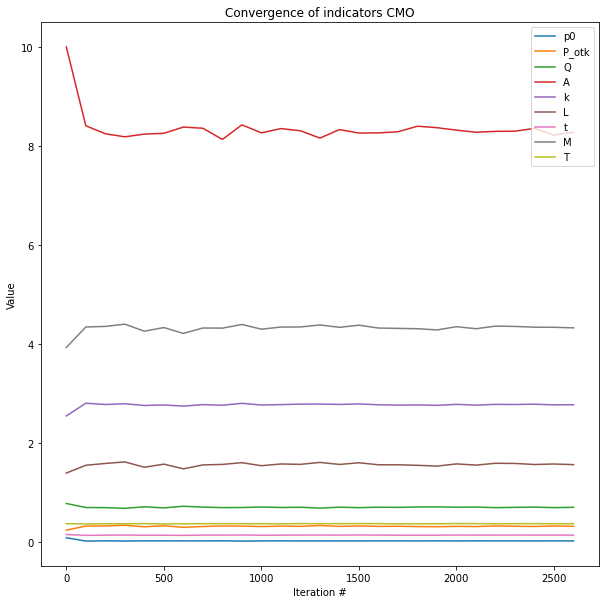

In [19]:
plt.figure(figsize=(10, 10))
for column in df.columns:
    plt.plot(df[column], label=column)
    plt.legend()
plt.title('Convergence of indicators CMO')
plt.xlabel('Iteration #')
plt.ylabel('Value')
plt.show()

Тогда будем считать, что СМО сходится, когда время симуляции превышает значение $\approx$ 2500. Поскольку мы имеем дело все-таки со случайными процессами, то сходимость может быть достигнута при разном значении итераций, но практика показала, что при нашем эпсилон, обычно сходимость достигается менее, чем за 10000 итераций (utils=10000). Запустим тогда 200 симуляций (очень долго считает, поэтому не много) с временем симуляции 10000. Итоговые показатели усредним, визуализируем и будем сравнивать с аналитическим решением.

In [20]:
df = pd.DataFrame({'p0':[],
                   'P_otk':[],
                   'Q':[],
                   'A':[],
                   'k':[],
                   'L':[],
                   't':[],
                   'M':[],
                   'T':[]})

for i in tqdm(range(200)):
    clients_total, clients_gone = [0 for x in range(2)]
    wait_times, len_queue, clients_in_CMO, clients_in_process, wait_time_in_queue = [[] for x in range(5)]
    emitation_time = 10000

    env = simpy.Environment()
    env.process(run_barber_shop(env))
    env.run(until=emitation_time)
    df.loc[i+1] = [round(clients_in_process.count(0)/clients_total, 5),
           round(clients_gone/clients_total, 5),
           round(1 - clients_gone/clients_total, 5),
           round((clients_total-clients_gone)/emitation_time, 5),
           round(np.mean(clients_in_process), 5),
           round(np.mean(len_queue), 5),
           round(np.mean(wait_time_in_queue), 5),
           round(np.mean(clients_in_CMO), 5),
           round(np.mean(wait_times), 5)]

In [21]:
df.describe()

,p0,P_otk,Q,A,k,L,t,M,T
count,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.012209,0.307652,0.692348,8.30693,2.768272,1.557649,0.129802,4.325921,0.360525
std,0.000444,0.002424,0.002424,0.02447,0.003830,0.008373,0.000628,0.011655,0.000994
min,0.011110,0.298500,0.685440,8.23790,2.757550,1.531100,0.128190,4.295080,0.358120
25%,0.011877,0.306243,0.690725,8.29175,2.765205,1.552190,0.129383,4.317870,0.359830
50%,0.012210,0.307785,0.692215,8.30225,2.768145,1.557610,0.129750,4.326000,0.360630
75%,0.012503,0.309275,0.693757,8.32075,2.770925,1.563350,0.130267,4.333905,0.361223
max,0.013380,0.314560,0.701500,8.40310,2.777910,1.582610,0.131390,4.359450,0.363100


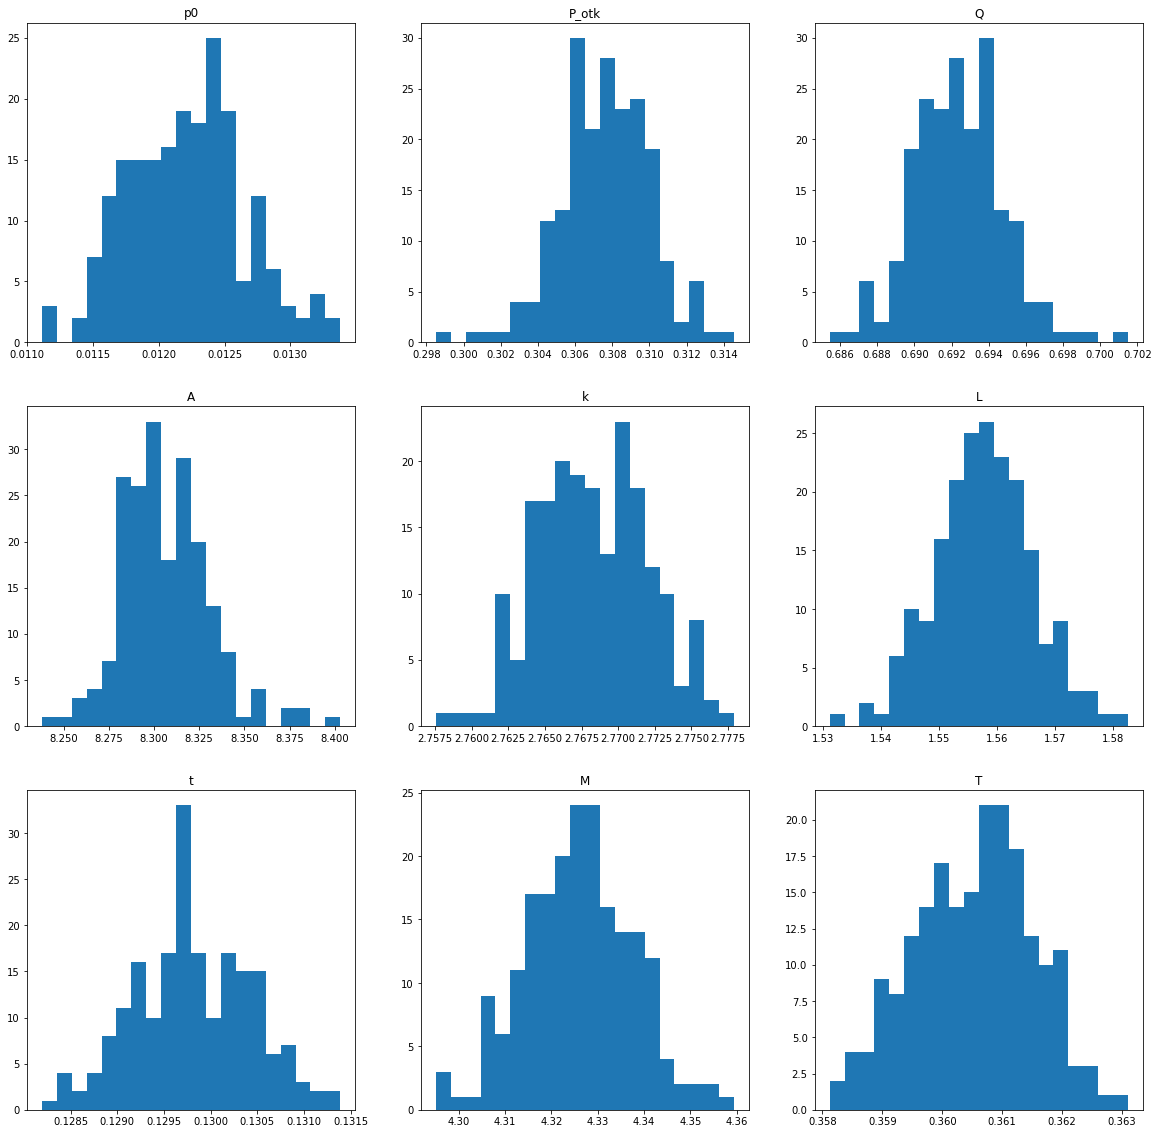

In [22]:
plt.figure(figsize=(20, 20))
for i, column in enumerate(df.columns):
    plt.subplot(3,3,i+1)
    plt.hist(df[column], bins=20)
    plt.title(column)
plt.show()

In [23]:
imitation_vs_analysis.loc['imitation'] = [df[column].mean() for column in df.columns]
imitation_vs_analysis

,p0,P_otk,Q,A,k,L,t,M,T
analysis,0.012170,0.307830,0.692170,8.30603,2.768680,1.558390,0.129870,4.327070,0.360590
imitation,0.012209,0.307652,0.692348,8.30693,2.768272,1.557649,0.129802,4.325921,0.360525


Как можно заметить, наша имитационная модель на Python более, чем сходится с аналитическим решением. Все показатели имеют +- нормальное распределение, что не может не радовать. Имитационные показатели почти не отличаются от аналитических. Небольшое отклонение можно списать на случайность процессов. В нашей задаче это поток клиентов и среднее время обслуживания, для которых интервал времени между двумя произвольными соседними событиями имеет показательное распределение.

Надеюсь, мы откажемся от имитации задач на питоне, это было весьма познавательно, но, пожалуйста, хватит)